# 2DOF Beam

The general mathematical representation of a single degree of freedom system is expressed using Newton's second law. It is a linear, time invariant, second order differential equation.

\begin{equation}
M \ddot{x} \left ( t \right ) + C \dot{x}\left (t \right ) + K x \left (t \right ) = f \left (t \right )
\end{equation}



## Setup



In [2]:
import numpy as np
from scipy import linalg as la
import matplotlib.pyplot as plt

show = lambda x,y: print('{}:\n{}\n'.format(x,y))

## Build Beam



In [3]:
b = 1              # in
h = 12             # in
I = b*(h**3)/12       # in^4
E = 29e6           # psi 
l = 100*12         # ft -> in
grav = 386.4       # in/sec^2;
mbar = b*h*.29     # vol * density -> lbf
mbar = mbar/grav   # lbm

# define discrete boundary springs
k1 = E*I/(l**3) * 300
k2 = E*I/l**3 * 300

# form mass matrix, [M]
M = mbar*l/2 * np.eye(2)

# form stiffness matrix, [K] from beam and springs
k = E*I/(l**3)  * np.array([[12, -12 ] , [-12, 12]])
K = k + np.eye(2)*np.array([k1,k2]) 


show('Mass matrix',M)
show('Stiffness matrix',K)

Mass matrix:
[[ 5.40372671  0.        ]
 [ 0.          5.40372671]]

Stiffness matrix:
[[ 754.  -29.]
 [ -29.  754.]]



## Eigenvalue Decomposition



Modal vectors and system poles (damped natural frequencies).

Proportionally damped system - modal vectors are always real (normal) modes. Therefore, the conjugate of a modal vector is the same as the modal vector.


In [4]:
# decomposition (use hermetian for square matrices) 
d, v = la.eigh(K,M)

# damped natural frequencies [rad/sec]
w = np.sqrt(d)

# decoupled mass and stiffness matrices
# note that the two matrix multiplication's below are equivalent. 
Mr = np.dot(np.dot(v.T,M), v) # works but ugly
Kr = v.T@K@v                  # works but only in python3.5+


# proportional damping [5% critical]
dampr = .05

# damping factor [rad/sec]
dampf = -dampr*w

# damped natural frequency [rad/sec]
wn = np.sqrt(w**2 + dampf**2)

# form positive poles
roots = dampf + 1j*wn


show('Eigenvalues',d)
show('Eigenvectors',v)
show('Decoupled Mass Matrix', Mr)
show('Decoupled Stiffness Matrix',Kr)

Eigenvalues:
[ 134.16666667  144.9       ]

Eigenvectors:
[[-0.30418536 -0.30418536]
 [-0.30418536  0.30418536]]

Decoupled Mass Matrix:
[[  1.00000000e+00  -2.33377532e-17]
 [ -2.33377532e-17   1.00000000e+00]]

Decoupled Stiffness Matrix:
[[  1.34166667e+02   5.94466183e-15]
 [  6.12689641e-16   1.44900000e+02]]



## Beam Plots

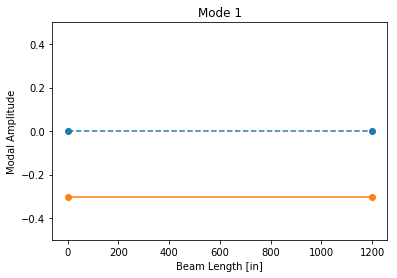

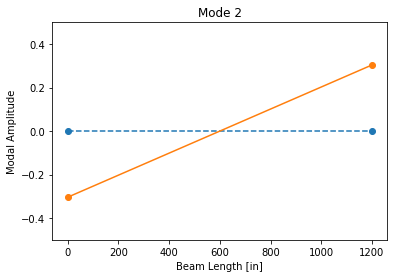

In [27]:
coords = np.array([[0,l],[0,0]])

def plot_undeformed(ax):
    ax.plot(coords[0,:], coords[1,:],'o--')

# plot each mode
for mode in range(v.shape[1]):
    
    fig, ax = plt.subplots()
    
    # plot beam
    plot_undeformed(ax)

    # superimpose modal vectors
    ax.plot(coords[0,:]+v[:,mode], coords[1,:]+v[:,mode],'o-')
    
    
    # format plot
    plt.ylim(-.5,.5)
    plt.xlabel('Beam Length [in]')
    plt.ylabel('Modal Amplitude')
    plt.title('Mode {}'.format(mode+1))
    plt.show()
    #fig.savefig('beam_2dof_mode{}.png'.format(mode+1))

## Transfer Function

Form transfer function from partial fraction expansion form


In [34]:
ns = 128
ne = v.shape[1] # number of effective modes

# general modal scaling, Qr
qr = 1/(2j*np.diag(Mr)*wn)

# scaled residues [Ar] for each mode (numerator)
A = [qr[mode]*np.outer(v[:,mode],v[:,mode]) for mode in np.arange(ne)]


freqs = np.linspace(-25,25,ns)

HH = np.zeros((v.shape[0],v.shape[1],ns))

def frf_build_sdof(a,r,f):
    """builds 1d array of sdof frequency response function by 
    evaluating residue and pole along a given frequency domain"""
    h = a/(1j*f-r) + np.conj(a)/(1j*f-np.conj(r))
    return h

for mode in np.arange(ne):
    pass
    #h = A[::,::,None] * frf_build_sdof
    
# form classic [no x ni x ns] FRF
iin = 1
iout = 1

mode = 0

#h = frf_build_sdof(A[mode], roots[mode], freqs)


def mag2db(x):
    return 20*np.log10(x)


### Frequency Response Function (FRF) Plots



In [2]:
plt.close()

mode = 1
iin = 0
iout = 0
h = frf_build_sdof(A[mode][iout][iin],roots[mode],freqs)

plt.plot(freqs,mag2db(np.abs(h)),'o--')
plt.grid('on')
plt.show()


NameError: name 'plt' is not defined

## Shape Estimation (CMIF via SVD)



[array([[ 0.-0.00398917j,  0.-0.00398917j],
        [ 0.-0.00398917j,  0.-0.00398917j]]),
 array([[ 0.-0.00383858j,  0.+0.00383858j],
        [ 0.+0.00383858j,  0.-0.00383858j]])]

## Pole Estimation (eFRF)



## Modal Flexibility